In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import polars as pl
import lightgbm as lgb
import joblib
from lightgbm import LGBMRegressor

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)

polars.config.Config

In [2]:
multi_index = ['date_id', 'time_id', 'symbol_id']
feature_col = [f'feature_{i:02d}' for i in range(79)]

weight = ['weight']
target = ['responder_6']
start_date = 1100
interest_col = multi_index + feature_col + weight + target

In [3]:
df = (pl.scan_parquet('data/train_with_lag.parquet')
      .sort(['date_id', 'symbol_id', 'time_id', ])
      .collect())
print(df.shape)

(22142032, 93)


In [4]:
df.head()

date_id,time_id,symbol_id,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,weight,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1100,0,0,0.347117,0.496246,-0.252778,0.300495,2.283821,-0.358535,1.499545,0.163361,0.522466,11,7,76,-1.018732,0.160037,-0.695186,null,0.966189,null,-1.041664,-1.200563,1.08635,-0.198352,0.497893,1.451918,-1.182287,-1.02238,0.891338,0.824079,0.987703,0.071278,0.675787,-0.179226,null,null,-0.432981,-0.387139,-1.033333,0.115463,0.144211,null,-0.104414,null,null,-1.438618,null,-2.239299,1.204056,-2.054071,-0.987095,-0.350367,null,0.554282,null,null,-0.963888,null,-2.11783,0.946514,null,-0.378454,-0.231735,0.747711,-0.366339,-0.179765,-0.334015,-1.798993,-1.743881,-0.904236,0.557061,-0.345155,-0.721083,-0.315582,-0.879035,null,null,-0.435363,-0.307379,-0.185087,-0.343539,2.135293,0.814512,-0.808547,-0.073002,1.378468,-1.702946,-0.630515,-0.150434,-0.337349,-0.135302,-0.976292
1100,1,0,0.498483,0.818084,0.290626,-0.390693,2.556569,-0.425948,1.546645,0.384382,0.414291,11,7,76,-0.950608,0.039547,-0.579912,null,1.523641,null,-0.805599,-1.557442,1.08635,-0.198352,0.497893,1.451918,-1.182287,-1.02238,0.891338,0.824079,0.987703,0.071278,0.675787,-0.179226,null,null,0.104987,0.207888,-1.015914,0.166151,0.335446,null,-0.281827,null,null,0.369755,null,-1.798086,0.658228,-2.316001,-0.318262,-0.473743,null,0.657237,null,null,-1.503625,null,-1.650383,2.127979,null,-0.466968,-0.218739,0.747711,-0.273781,-0.323588,-0.325117,-0.962993,-1.624149,-0.771753,0.338929,-0.345087,-1.078016,-0.42061,-0.875393,null,null,-0.309435,-0.364328,-0.3419,-0.379011,2.135293,0.251151,-0.808547,-0.073002,1.378468,-1.702946,-0.630515,-0.150434,-0.337349,-0.135302,-0.976292
1100,2,0,0.065002,0.849842,-0.483166,-0.20876,2.196108,-0.252584,1.816396,0.906599,0.414356,11,7,76,-0.634386,-0.129347,-0.721756,null,1.452684,null,-1.31158,-1.165897,1.08635,-0.198352,0.497893,1.451918,-1.182287,-1.02238,0.891338,0.824079,0.987703,0.071278,0.675787,-0.179226,null,null,-0.413711,-0.333547,-0.927413,0.117257,0.297455,null,0.148132,null,null,0.723145,null,-1.017841,0.474401,-2.221631,-0.1914,-0.484941,null,1.513084,null,null,-1.107442,null,-1.615432,1.693742,null,-0.156823,-0.282838,0.747711,-0.283872,-0.320515,-0.284345,-1.00214,-1.99958,-1.128644,0.177068,-0.36073,-1.35471,-0.280322,-0.76463,null,null,-0.314717,-0.272388,-0.232066,-0.380518,2.135293,0.528795,-0.808547,-0.073002,1.378468,-1.702946,-0.630515,-0.150434,-0.337349,-0.135302,-0.976292
1100,3,0,0.328502,0.814784,0.183059,0.17839,2.60874,-0.577274,0.35439,0.224877,0.373623,11,7,76,-0.798601,-0.263698,-0.462612,null,1.447068,null,-1.187436,-0.97765,1.08635,-0.198352,0.497893,1.451918,-1.182287,-1.02238,0.8

In [5]:
X = df.drop(multi_index+weight+target).to_pandas()
y = df[target].to_pandas()
sample_weight = df[weight].to_pandas().values.flatten()

In [6]:
parm = {'n_estimators':1500, 'max_depth':6, 'num_leaves':64, 'learning_rate':0.05,
        'colsample_bytree':0.5, 'subsample':0.5, 'subsample_freq':100,
        'importance_type':'gain', 'boosting_type':'dart' ,'random_state':0, 'n_jobs':-1}
model = LGBMRegressor(**parm)

In [7]:
model.fit(X, y, sample_weight=sample_weight)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.222631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21737
[LightGBM] [Info] Number of data points in the train set: 22142032, number of used features: 88
[LightGBM] [Info] Start training from score -0.001739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

LGBMRegressor(boosting_type='dart', colsample_bytree=0.5,
              importance_type='gain', learning_rate=0.05, max_depth=6,
              n_estimators=1500, n_jobs=-1, num_leaves=64, random_state=0,
              subsample=0.5, subsample_freq=100)

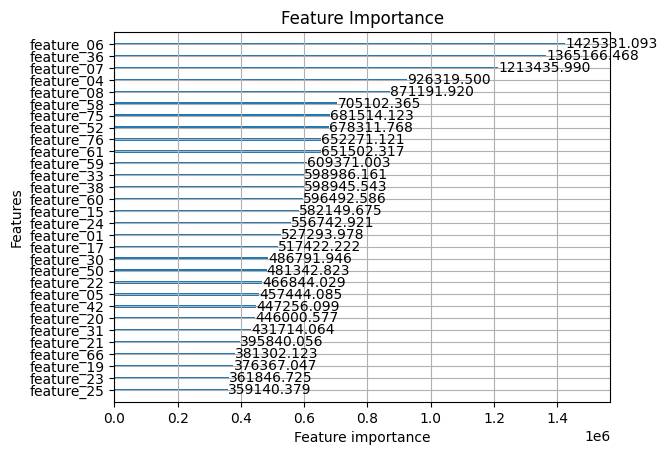

In [8]:
lgb.plot_importance(model, max_num_features=30, importance_type='gain')  # 或 'gain'
plt.title("Feature Importance")
plt.show()

In [9]:
data = {
    'model' : model, 
    'feature' : X.columns.tolist(),
    'parmaters' : parm
    }

joblib.dump(data, './model/lgbm_lag_d6_n1500_sub5.pkl')

['./model/lgbm_lag_d6_n1500_sub5.pkl']